# Computer Vision Assignment 2
Metehan Seyran <br />
150170903

In [2]:
import numpy as np
import cv2
import dlib
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import os
import moviepy.editor as mpy

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)1982464/45929032 bytes (4.3%)5152768/45929032 bytes (11.2%)8388608/45929032 bytes (18.3%)11780096/45929032 bytes (25.6%)15015936/45929032 bytes (32.7%)18505728/45929032 bytes (40.3%)22134784/45929032 bytes (48.2%)25395200/45929032 bytes (55.3%)28598272/45929032 bytes (62.3%)32055296/45929032 bytes (69.8%)35446784/45929032 bytes (77.2%)38739968/45929032 bytes (84.3%)

## Part 1: Showing the landmark points

In [3]:
human_faces = ["aydemirakbas.png", "deniro.jpg", "kimbodnia.png"]
animal_faces = sorted(["cat.jpg", "gorilla.jpg", "panda.jpg"])

human_face_landmarks = []
animal_face_landmarks = []

animal_landmarks = []
for file in os.listdir():
  if file.endswith(".npy"):
    animal_landmarks.append(file)
animal_landmarks = sorted(animal_landmarks)

In [4]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

def get_points(img_name):
  image = cv2.imread(img_name)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

  rectangles = detector(gray)
  points = predictor(gray, rectangles[0])

  return image, rectangles, points

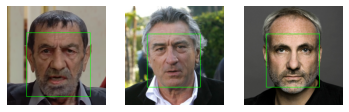

In [5]:
fig, axs = plt.subplots(1, 3)

for i, face in enumerate(human_faces):
  img, rects, _ = get_points(face)

  top_left_x, top_left_y = rects[0].tl_corner().x, rects[0].tl_corner().y
  bottom_right_x, bottom_right_y = rects[0].br_corner().x, rects[0].br_corner().y

  img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  img_rgb[top_left_y-1:top_left_y+1, top_left_x:bottom_right_x] = [0,255,0]
  img_rgb[top_left_y:bottom_right_y, top_left_x-1:top_left_x+1] = [0,255,0]
  img_rgb[bottom_right_y-1:bottom_right_y+1, top_left_x:bottom_right_x] = [0,255,0]
  img_rgb[top_left_y:bottom_right_y, bottom_right_x-1:bottom_right_x+1] = [0,255,0]

  axs[i].axis("off")
  axs[i].imshow(img_rgb)

In [6]:
def show_human_face(ax, human_face):

  img, rects, pts = get_points(human_face)
  im_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  ax.axis("off")
  ax.imshow(im_rgb)
  points = []
  for i in range(68):
    points.append([pts.part(i).x, pts.part(i).y])
    ax.scatter(pts.part(i).x, pts.part(i).y, c='lime', s=2)

  human_face_landmarks.append(points)

In [7]:
def show_animal_face(idx, ax):
  landmarks = np.load(animal_landmarks[idx])
  animal_face_landmarks.append(landmarks)

  image = cv2.imread(animal_faces[idx])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  ax.axis("off")
  ax.imshow(image)
  for i in range(68):
    ax.scatter(landmarks[i, 0], landmarks[i, 1], s=2, c="lime")

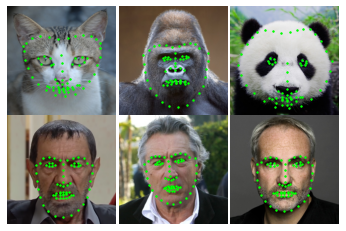

In [8]:
fig, axs = plt.subplots(2, 3, gridspec_kw={'hspace': 0, 'wspace': 0})

animal_axs, human_axs = axs

for idx in range(len(human_axs)):
  show_animal_face(idx, animal_axs[idx])
  show_human_face(human_axs[idx], human_faces[idx])

## Part 2: Delaunay Triangulation

In [9]:
## Appendind edge and corner locations and converting landmarks to numpy arrays
human_face_landmarks = np.array(human_face_landmarks)
animal_face_landmarks = np.array(animal_face_landmarks)

In [10]:
def find_vertexes(src_image, src_landmarks):
  image = cv2.imread(human_faces[0])
  subdiv = cv2.Subdiv2D((0, 0, image.shape[0], image.shape[1]))

  for i in range(68):
    subdiv.insert(tuple(src_landmarks[i][:]))

  subdiv.insert((0,0))
  subdiv.insert((0, image.shape[1]//2))
  subdiv.insert((0, image.shape[1]-1))
  subdiv.insert((image.shape[0]-1, 0))
  subdiv.insert((image.shape[0]-1, image.shape[1]//2))
  subdiv.insert((image.shape[0]-1, image.shape[1]-1))
  subdiv.insert((image.shape[0]//2, 0))
  subdiv.insert((image.shape[0]//2, image.shape[1]-1))

  not_landmark = []  
  not_landmark.append([0, 0])
  not_landmark.append([0, image.shape[1]//2])
  not_landmark.append([0, image.shape[1]-1])
  not_landmark.append([image.shape[0]-1, 0])
  not_landmark.append([image.shape[0]-1, image.shape[1]//2])
  not_landmark.append([image.shape[0]-1, image.shape[1]-1])
  not_landmark.append([image.shape[0]//2, 0])
  not_landmark.append([image.shape[0]//2, image.shape[1]-1])
  not_landmark = np.array(not_landmark)


  triangles = subdiv.getTriangleList()

  vertex_ids = np.zeros((triangles.shape[0], 3), dtype="int32")
  for i in range(triangles.shape[0]):
    for j in range(3):
      for k in range(76):
        if k < 68 and (src_landmarks[k][:] == triangles[i, 2*j:2*j+2]).all():
          vertex_ids[i, j] = k
        elif k >= 68 and (not_landmark[k%68, :] == triangles[i, 2*j:2*j+2]).all():
          vertex_ids[i, j] = k
  return vertex_ids, triangles, not_landmark

In [11]:
def id2triangles(vertex_ids, landmarks, not_landmark):
  triangles = np.zeros((vertex_ids.shape[0], 6))
  for i in range(vertex_ids.shape[0]):
    for j in range(3):
      if vertex_ids[i, j] < 68:
        triangles[i, 2*j] = landmarks[vertex_ids[i, j]][0]
        triangles[i, 2*j+1] = landmarks[vertex_ids[i, j]][1]
      else:
        triangles[i, 2*j] = not_landmark[vertex_ids[i, j]%68, 0]
        triangles[i, 2*j+1] = not_landmark[vertex_ids[i, j]%68, 1]
  return triangles

In [12]:
def plot_triangles(img_name, landmarks, not_landmark, vertex_ids, ax, isAnimal=False):
  x = np.hstack((landmarks[:,0], not_landmark[:,0]))
  y = np.hstack((landmarks[:,1], not_landmark[:,1]))

  triang = mtri.Triangulation(x, y, vertex_ids)
  
  if not isAnimal:
    img = get_points(img_name)[0]
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  else:
    img = cv2.imread(img_name)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  ax.triplot(triang, c='lime', lw=0.5, )
  ax.axis("off")
  ax.imshow(img_rgb)

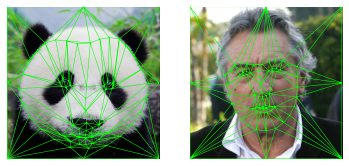

In [13]:
ids1, triangles1, not_landmarks = find_vertexes(human_faces[0], human_face_landmarks[0])
fig, axs = plt.subplots(1,2)
plot_triangles(animal_faces[2], animal_face_landmarks[2], not_landmarks, ids1, axs[0], True)
plot_triangles(human_faces[1], human_face_landmarks[1], not_landmarks, ids1, axs[1])

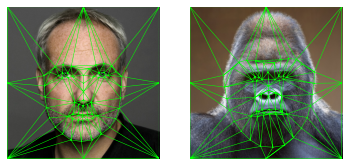

In [14]:
ids2, triangles2, not_landmarks = find_vertexes(human_faces[2], human_face_landmarks[2])
fig, axs = plt.subplots(1,2)
plot_triangles(human_faces[2], human_face_landmarks[2], not_landmarks, ids2, axs[0])
plot_triangles(animal_faces[1], animal_face_landmarks[1], not_landmarks, ids2, axs[1], True)

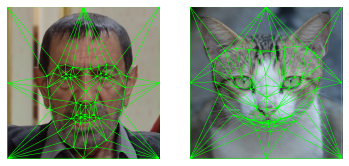

In [15]:
ids3, triangles3, not_landmarks = find_vertexes(human_faces[0], human_face_landmarks[0])
fig, axs = plt.subplots(1,2)
plot_triangles(human_faces[0], human_face_landmarks[0], not_landmarks, ids3, axs[0])
plot_triangles(animal_faces[0], animal_face_landmarks[0], not_landmarks, ids3, axs[1], True)

## Part 3 - Face Morphing

In [16]:
#This part will convert Panda to Kim Bodnia
img1_triangles = id2triangles(ids1, animal_face_landmarks[1], not_landmarks)
img2_triangles = id2triangles(ids1, human_face_landmarks[1], not_landmarks)
img1 = cv2.imread(animal_faces[1])
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread(human_faces[1])
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

In [17]:
def make_homogeneous(triangle):
  homogeneous = np.array([triangle[::2], \
                          triangle[1::2], \
                          [1, 1, 1]]) #(C)
  return homogeneous

def calc_transform(triangle1, triangle2):
  source = make_homogeneous(triangle1).T #(3,3)
  target = triangle2
  Mtx = np.array([np.concatenate((source[0], np.zeros(3))),
                  np.concatenate((np.zeros(3), source[0])),
                  np.concatenate((source[1], np.zeros(3))),
                  np.concatenate((np.zeros(3), source[1])),
                  np.concatenate((source[2], np.zeros(3))),
                  np.concatenate((np.zeros(3), source[2]))])#(D)
  coefs = np.matmul(np.linalg.pinv(Mtx), target)#(E)
  Transform = np.array([coefs[:3], coefs[3:], [0, 0, 1]])#(F)
  return Transform

def vectorised_Bilinear(coordinates, target_img, size):
  coordinates[0] = np.clip(coordinates[0], 0, size[0]-1)
  coordinates[1] = np.clip(coordinates[1], 0, size[1]-1)
  lower = np.floor(coordinates).astype(np.uint32)
  upper = np.ceil(coordinates).astype(np.uint32)

  error = coordinates - lower
  resindual = 1-error

  top_left = np.multiply(np.multiply(resindual[0], resindual[1]).reshape(coordinates.shape[1], 1), target_img[lower[0], lower[1], :])
  top_right = np.multiply(np.multiply(resindual[0], error[1]).reshape(coordinates.shape[1], 1), target_img[lower[0], upper[1], :])
  bot_left = np.multiply(np.multiply(error[0], resindual[1]).reshape(coordinates.shape[1], 1), target_img[upper[0], lower[1], :])
  bot_right = np.multiply(np.multiply(error[0], error[1]).reshape(coordinates.shape[1], 1), target_img[upper[0], upper[1], :]) #(G)

  return np.uint8(np.round(top_left + top_right + bot_left + bot_right)) #(H)

def image_morph(image1, image2, triangles1, triangles2, transforms, t):
  inter_image_1 = np.zeros(image1.shape).astype(np.uint8)
  inter_image_2 = np.zeros(image2.shape).astype(np.uint8)

  for i in range(len(transforms)):
    homo_inter_tri = (1-t)*make_homogeneous(triangles1[i]) + t*make_homogeneous(triangles2[i]) #(I)

    polygon_mask = np.zeros(image1.shape[:2], dtype=np.uint8)
    cv2.fillPoly(polygon_mask, [np.int32(np.round(homo_inter_tri[1::-1,:].T))], color=255) #(J)
    
    seg = np.where(polygon_mask == 255)#(K)
    
    mask_points = np.vstack((seg[0], seg[1], np.ones(len(seg[0]))))#(L)
    
    inter_tri = homo_inter_tri[:2].flatten(order="F")#(M)
    
    inter_to_img1 = calc_transform(inter_tri, triangles1[i])
    inter_to_img2 = calc_transform(inter_tri, triangles2[i])
    
    mapped_to_img1 = np.matmul(inter_to_img1, mask_points)[:-1]#(N)
    mapped_to_img2 = np.matmul(inter_to_img2, mask_points)[:-1]
    
    inter_image_1[seg[0], seg[1], :] = vectorised_Bilinear(mapped_to_img1, image1, inter_image_1.shape)#(O)
    inter_image_2[seg[0], seg[1], :] = vectorised_Bilinear(mapped_to_img2, image2, inter_image_2.shape)

  result = (1-t)*inter_image_1 + t*inter_image_2 #(p)

  return result.astype(np.uint8)

img1_triangles = img1_triangles[:, [1, 0, 3, 2, 5, 4]]
img2_triangles = img2_triangles[:, [1, 0, 3, 2, 5, 4]]

Transforms = np.zeros((len(img1_triangles), 3, 3))
for i in range(len(img1_triangles)):
  source = img1_triangles[i]
  target = img2_triangles[i]
  Transforms[i] = calc_transform(source, target) #(A)

morphs = []
for t in np.arange(0, 1.0001, 0.02): #(B)
  print("processing:\t", int(t*100), "%")
  morphs.append(image_morph(img1, img2, img1_triangles, img2_triangles, Transforms, t)[:, :, [0,1,2]])

processing:	 0 %
processing:	 2 %
processing:	 4 %
processing:	 6 %
processing:	 8 %
processing:	 10 %
processing:	 12 %
processing:	 14 %
processing:	 16 %
processing:	 18 %
processing:	 20 %
processing:	 22 %
processing:	 24 %
processing:	 26 %
processing:	 28 %
processing:	 30 %
processing:	 32 %
processing:	 34 %
processing:	 36 %
processing:	 38 %
processing:	 40 %
processing:	 42 %
processing:	 44 %
processing:	 46 %
processing:	 48 %
processing:	 50 %
processing:	 52 %
processing:	 54 %
processing:	 56 %
processing:	 57 %
processing:	 60 %
processing:	 62 %
processing:	 64 %
processing:	 66 %
processing:	 68 %
processing:	 70 %
processing:	 72 %
processing:	 74 %
processing:	 76 %
processing:	 78 %
processing:	 80 %
processing:	 82 %
processing:	 84 %
processing:	 86 %
processing:	 88 %
processing:	 90 %
processing:	 92 %
processing:	 94 %
processing:	 96 %
processing:	 98 %
processing:	 100 %


In [18]:
def prepareVideo(images_list, part_name="1"):
  clip = mpy.ImageSequenceClip(images_list, fps = 25)
  clip.write_videofile("Part"+part_name+"_video.mp4", codec='libx264')

prepareVideo(morphs, "3")

[MoviePy] >>>> Building video Part3_video.mp4
[MoviePy] Writing video Part3_video.mp4


100%|██████████| 52/52 [00:00<00:00, 133.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Part3_video.mp4 

